In [80]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
import os
import cmocean
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [32]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [3]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [4]:
mat = sio.loadmat('/ocean/rchappel/MATLAB/PSFc2017.mat')

In [5]:
ctd_data = mat[list(mat.keys())[3]]

In [6]:
ctd_dtype = ctd_data.dtype

In [7]:
ctddata = {n: ctd_data[n][0, 0] for n in ctd_dtype.names}

In [11]:
ctddata['mtime'].shape

(1, 1181)

In [13]:
base = datetime.datetime(2000, 1, 1)
py_ctd_times = np.array([base for i in range(1181)])
print(py_ctd_times.shape)
for n in range(1181):
    py_ctd_times[n] = ((datetime.datetime.fromordinal(int(ctddata['mtime'][0,n])))
                       + datetime.timedelta(days=ctddata['mtime'][0,n]%1)
                       - datetime.timedelta(days = 366))

(1181,)


In [14]:
ctddata.keys()

dict_keys(['pr', 'temp', 'sal', 'cond', 'depth', 'patrol', 'mtime', 'lat', 'long', 'stn'])

In [19]:
lats = ctddata['lat'][0,:]
lons = ctddata['long'][0,:]

In [42]:
ctddata['depth'] = np.ma.masked_invalid(ctddata['depth'])
ctddata['temp'] = np.ma.masked_invalid(ctddata['temp'])
sals = np.ma.masked_invalid(ctddata['sal'])

In [38]:
hour = np.array([])
for n in py_ctd_times:
    hour = np.append(hour, n.hour)

In [47]:
f = nc.Dataset('/results/SalishSea/nowcast-green/01feb18/SalishSea_1d_20180201_20180201_dia2_T.nc')
deptht = f.variables['deptht'][:]

In [51]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
tmask = mesh.variables['tmask'][:]

In [56]:
list_of_Yinds = np.array([])
list_of_Xinds = np.array([])
for m in range(1181):
    Yind, Xind = geo_tools.find_closest_model_point(lons[m],
                                                    lats[m], 
                                                    X, Y, land_mask = bathy.mask)
    list_of_Yinds = np.append(list_of_Yinds, Yind)
    list_of_Xinds = np.append(list_of_Xinds, Xind)

In [57]:
np.ma.count(np.ma.masked_invalid(list_of_Yinds))

1081

In [58]:
list_of_Yinds2 = np.ma.masked_invalid(list_of_Yinds)

In [63]:
list_of_model_sal = np.ones((200,1181)) * 9999
list_of_model_temp = np.ones((200,1181)) * 9999
for m in range(1181):
    if list_of_Yinds2.mask[m] == False:
        Yind = int(list_of_Yinds[m])
        Xind = int(list_of_Xinds[m])
        date = py_ctd_times[m]
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, 
                                       day = date.day, hour = (date.hour), 
                                       minute = 30) - datetime.timedelta(hours=1)
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, 
                                       day = date.day, hour = (date.hour), 
                                       minute = 30)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date.minute + 30) / 60
        for n in range(200):
            if sals.mask[n,m] == False:
                depth = np.abs((deptht - ctddata['depth'][n, m])).argmin()
                if tmask[0,depth,Yind,Xind] == 1:
                    t_val = ((1-delta)*(nuts.variables['votemper'][before.hour, depth, Yind, Xind] ) + 
                              (delta)*(nuts2.variables['votemper'][after.hour, depth, Yind, Xind] ))
                    s_val = ((1-delta)*(nuts.variables['vosaline'][before.hour, depth, Yind, Xind] ) + 
                               (delta)*(nuts2.variables['vosaline'][after.hour, depth, Yind, Xind] ))
                    list_of_model_sal[n, m] = s_val
                    list_of_model_temp[n, m] = t_val

In [64]:
list_of_model_sal.shape

(200, 1181)

In [65]:
list_of_model_sal2 = np.ma.masked_greater(list_of_model_sal, 900)
list_of_model_temp2 = np.ma.masked_greater(list_of_model_temp, 900)

In [66]:
list_of_model_sal2.max()

32.26150894165039

In [67]:
np.ma.count(list_of_model_sal2)

118059

In [69]:
np.ma.count(ctddata['sal'])

126009

In [70]:
ctddata['sal'].mask = list_of_model_sal2.mask
ctddata['temp'].mask = list_of_model_temp2.mask

In [71]:
np.ma.count(ctddata['sal'])

118059

In [72]:
list_of_model_sal2.mask = ctddata['sal'].mask 
list_of_model_temp2.mask = ctddata['temp'].mask 

In [73]:
list_of_model_sal2.max()

32.26150894165039

In [74]:
ctddata['sal'].max()

32.139666

In [76]:
plottable_cs_sals =ctddata['sal'].compressed()
plottable_cs_temps = ctddata['temp'].compressed()
plottable_model_sals = list_of_model_sal2.compressed()
plottable_model_temps = list_of_model_temp2.compressed()
plottable_model_sals.max()

32.26150894165039

In [77]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12

In [78]:
plottable_cs_sals.shape

(118059,)

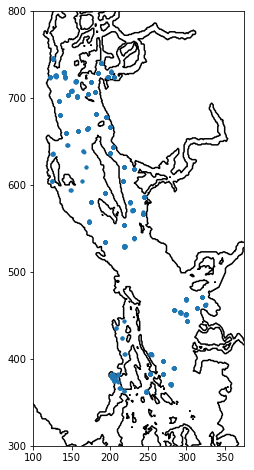

In [95]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.plot_coastline(ax, grid)
viz_tools.set_aspect(ax)
ax.set_ylim(300, 800)
ax.set_xlim(100, 375)
ax.plot(list_of_Xinds, list_of_Yinds, '.');

bias =  0.39233559227915293
RMSE = 0.8003981811760156
Willmott = 0.9348053317503713


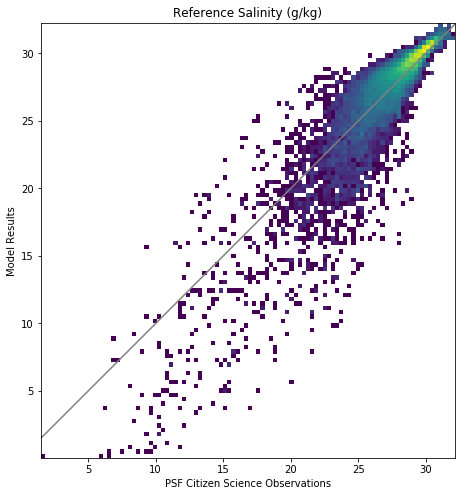

In [82]:
fig, ax = plt.subplots(figsize = (8, 8))
c, xedge, yedge, im = ax.hist2d(plottable_cs_sals, plottable_model_sals, 
                                     bins = 100, norm=LogNorm());
ax.set_title('Reference Salinity (g/kg)')
ax.set_xlabel('PSF Citizen Science Observations')
ax.set_ylabel('Model Results')
ax.set_aspect('equal')
ax.plot(np.arange(0,34), np.arange(0,34), color = 'grey')
print('bias =  ' + str(-np.mean(plottable_cs_sals) + np.mean(plottable_model_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((plottable_model_sals - plottable_cs_sals)**2) /
                              118059)))
xbar = np.mean(plottable_cs_sals)
print('Willmott = ' + str(1-(np.sum((plottable_model_sals - plottable_cs_sals)**2)  / 
                             np.sum((np.abs(plottable_model_sals - xbar) 
                                     + np.abs(plottable_cs_sals - xbar))**2))))

bias =  0.030829213671029976
RMSE = 0.5323857620830894
Willmott = 0.9735495669157884


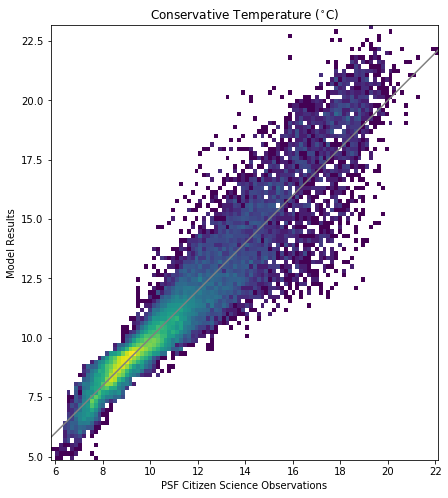

In [84]:
fig, ax = plt.subplots(figsize = (8, 8))
c, xedge, yedge, im = ax.hist2d(plottable_cs_temps, plottable_model_temps, 
                                     bins = 100, norm=LogNorm());
ax.set_title('Conservative Temperature ($^{\circ}$C)')
ax.set_xlabel('PSF Citizen Science Observations')
ax.set_ylabel('Model Results')
ax.set_aspect('equal')
ax.plot(np.arange(4,34), np.arange(4,34), color = 'grey')
print('bias =  ' + str(-np.mean(plottable_cs_temps) + np.mean(plottable_model_temps)))
print('RMSE = ' + str(np.sqrt(np.sum((plottable_model_temps - plottable_cs_temps)**2) /
                              118059)))
xbar = np.mean(plottable_cs_temps)
print('Willmott = ' + str(1-(np.sum((plottable_model_temps - plottable_cs_temps)**2)  / 
                             np.sum((np.abs(plottable_model_temps - xbar) 
                                     + np.abs(plottable_cs_temps - xbar))**2))))